In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

## set random seed
RND = 722

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data-mining-iter2').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


We load the transformed data from `1-data-preparation-data-transformation.ipynb`.

# 5. Data Mining Method Selection

Supervised learning: classification task.


# 6. Data Mining Algorithm Selection

- Logistic Regression

# 7. Data Mining

## 7.1. Create and Justify Test Designs

Train-validation-test. Use k-fold cross validation to estimate the performance in validation set.

We use similar train-test data as we used in feature selection and random oversampling.

In [3]:
import json
from pyspark.sql.types import StructType

## Get schema of the JSON file
with open("hotel_merged_data_transformation_schema.json") as f:
    new_schema = StructType.fromJson(json.load(f))

In [4]:
## Read the JSON file based on the saved schema
df_hotel = spark.read.json('hotel_merged_data_transformation.json/',
                          schema = new_schema)

In [5]:
## recheck number of observations
df_hotel.count()

141012

In [6]:
df_hotel.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: double (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- IsRepeatedGuest: boolean (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- DaysInWaitingList: integer (nullable = true)
 |-- ADR: double (nullable = true)
 |-- HasChild: boolean (nullable = true)
 |-- RequireCarPark: boolean (nullable = true)
 |-- HasSpecialRequest: boolean (nullable = true)
 |-- IsReservedRoomTypeEqualToAssigned: boolean (nullable = true)
 |-- IsCityHotel: boolean (nullable = true)
 |-- MealVector: vector (nullable = true)
 |-- MarketSegmentVector: vector (nullable = true)
 |-- DistributionChannelVector: vector (nullable = true)
 |-- DepositTypeV

In [7]:
## split the dataframe based on previous train-test-split
df_train = df_hotel.filter('IsTestSet == False').drop('IsTestSet')
df_test = df_hotel.filter('IsTestSet == True').drop('IsTestSet')

## 7.2. Conduct Data Mining

Algorithms:
- Logistic Regression

We evaluate the models based on accuracy and AUC.

In [11]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def kfold_cv(spark_df,
             target_colname, 
             clf,
             k = 10,
             random_seed = 722,
             params = ParamGridBuilder(),
             eval_metric = 'accuracy',
             raw_prediction_colname = 'rawPrediction'
            ):
    """
    Perform k-fold cross-validation using the specified classifier.
    Return the cross-validated model.
    """
    params = params.build()

    assembler = VectorAssembler(
        inputCols = [colname for colname in spark_df.columns if (colname != target_colname)],
        outputCol = 'features'
    )

    pipeline = Pipeline(
        stages = [assembler, clf]
    )

    cv_binary = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = BinaryClassificationEvaluator(
            labelCol = target_colname, 
            rawPredictionCol = raw_prediction_colname,
            metricName = 'areaUnderROC'
        ),
        numFolds = k,
        seed = random_seed
    )
    
    cv_multi = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = MulticlassClassificationEvaluator(
            labelCol = target_colname, 
            metricName = eval_metric
        ),
        numFolds = k,
        seed = random_seed
    )
    
    ## Same model, but different evaluator
    ## We only want to store the average value of the evaluation metrics
    cv_model_binary = cv_binary.fit(spark_df)
    cv_model_multi = cv_multi.fit(spark_df)
    
    print("Cross-validation results")
    print("========================")
    print("AUC: {}".format(cv_model_binary.avgMetrics[0]))
    print("Accuracy: {}".format(cv_model_multi.avgMetrics[0]))
    
    ## Only return one model (both are similar)
    return cv_model_binary

In [12]:
from pyspark.ml.tuning import TrainValidationSplit

def train_val_split(spark_df,
                    target_colname, 
                    clf,
                    train_ratio = 0.7,
                    random_seed = 722,
                    params = ParamGridBuilder(),
                    raw_prediction_colname = 'rawPrediction'
                   ):
    """
    Perform k-fold cross-validation using the specified classifier.
    Return the cross-validated model.
    """
    params = params.build()

    assembler = VectorAssembler(
        inputCols = [colname for colname in spark_df.columns if (colname != target_colname)],
        outputCol = 'features'
    )

    pipeline = Pipeline(
        stages = [assembler, clf]
    )

    tv_binary = TrainValidationSplit(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = BinaryClassificationEvaluator(
            labelCol = target_colname, 
            rawPredictionCol = raw_prediction_colname,
            metricName = 'areaUnderROC'
        ),
        trainRatio = train_ratio,
        seed = random_seed
    )
    
    ## Same model, but different evaluator
    ## We only want to store the average value of the evaluation metrics
    tv_model_binary = tv_binary.fit(spark_df)
    
    ## Only return one model that maximises AUC
    return tv_model_binary

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_performance(clf, spark_df, target_colname, raw_prediction_colname = 'rawPrediction'):
    """
    Evaluate model performance on the given dataset.
    Return the AUC and accuracy.
    """
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol = target_colname,
        rawPredictionCol = raw_prediction_colname
    )
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol = target_colname,
        metricName = 'accuracy'
    )
    
    pred_df = clf.transform(spark_df)
    print("AUC: {}".format(binary_evaluator.evaluate(pred_df)))
    print("Accuracy: {}".format(multi_evaluator.evaluate(pred_df)))

### Logistic Regression A - Grid Search

Best parameter: regParam = 0.01, elasticNetParam = 0.

In [19]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import LogisticRegression

## If model has been trained, read pickled model via pipeline api
## If not, train the model and store the pickled model
LOGRES_MODEL_PATH = 'model/logistic_regression_iter2/'

if path.exists(LOGRES_MODEL_PATH):
    cv_logres = PipelineModel.load(LOGRES_MODEL_PATH)
else:
    logres = LogisticRegression(
        maxIter = 30, 
        family = 'binomial',
        labelCol = 'IsCanceled'
    )
    params = ParamGridBuilder().addGrid(
        logres.regParam, np.arange(0.01, 0.1, step = 0.03)
    ).addGrid(
        logres.elasticNetParam, np.arange(0, 0.9, step = 0.25)
    )
    
    tvs = train_val_split(
        df_train, 
        target_colname = 'IsCanceled', 
        params = params,
        clf = logres
    )
    
    ## cross-validation using best parameteres from train-validation split
    reg_param = tvs.bestModel.stages[-1]._java_obj.getRegParam()
    enet_param = tvs.bestModel.stages[-1]._java_obj.getElasticNetParam()
    
    logres_tuned = LogisticRegression(
        maxIter = 30, 
        regParam = reg_param,
        elasticNetParam = enet_param,
        family = 'binomial',
        labelCol = 'IsCanceled'
    )
    
    cv_logres = kfold_cv(df_train, target_colname = 'IsCanceled', clf = logres_tuned, k = 5)
    ## Save trained model
    cv_logres.bestModel.save(LOGRES_MODEL_PATH)

In [12]:
## On test set
evaluate_performance(cv_logres, df_test, target_colname = 'IsCanceled')

AUC: 0.8676570435930413
Accuracy: 0.783198363549752


### Logistic Regression B 

Additional tuning (manual), based on previous grid search result.

In [16]:
from pyspark.ml.pipeline import PipelineModel
from os import path
from pyspark.ml.classification import LogisticRegression

## If model has been trained, read pickled model via pipeline api
## If not, train the model and store the pickled model
LOGRES2_MODEL_PATH = 'model/logistic_regression_iter2_tweak-b/'

if path.exists(LOGRES2_MODEL_PATH):
    cv_logres2 = PipelineModel.load(LOGRES2_MODEL_PATH)
else:
    logres2 = LogisticRegression(
        maxIter = 100,
        regParam = 0,
        elasticNetParam = 0,
        aggregationDepth = 5,
        family = 'binomial',
        labelCol = 'IsCanceled'
    )
    
    cv_logres2 = kfold_cv(df_train, target_colname = 'IsCanceled', clf = logres2, k = 5)
    ## Save trained model
    cv_logres2.bestModel.save(LOGRES2_MODEL_PATH)

In [17]:
# from pyspark.ml.classification import LogisticRegression

# logres2 = LogisticRegression(
#     maxIter = 100,
#     regParam = 0,
#     elasticNetParam = 0,
#     aggregationDepth = 5,
#     family = 'binomial',
#     labelCol = 'IsCanceled'
# )

# cv_logres2 = kfold_cv(df_train, target_colname = 'IsCanceled', clf = logres2, k = 5)

In [18]:
## On test set
evaluate_performance(cv_logres2, df_test, target_colname = 'IsCanceled')

AUC: 0.8730843155266368
Accuracy: 0.7927816852074985


## 7.3. Search for Patterns

In [20]:
## store the feature list, so that we can extract them
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols = [colname for colname in df_train.columns if (colname != 'IsCanceled')],
    outputCol = 'features'
)

df_train_assembled = assembler.transform(df_train)

In [21]:
def get_feature_importance_score(feature_importance, spark_df, feature_colname):
    """
    Extract feature importance scores and combine them with the feature name.
    """
    attributes_dict = spark_df.schema[feature_colname].metadata["ml_attr"]["attrs"]
    attributes_list = []
    
    for key in attributes_dict:
        attributes_list = attributes_list + attributes_dict[key]
    
    df_attributes = pd.DataFrame(attributes_list)
    df_attributes['score'] = df_attributes['idx'].apply(lambda x: feature_importance[x])
    df_attributes = df_attributes.sort_values(
        'score', 
        ascending = False
    ).drop(
        labels = 'idx', 
        axis = 1
    )
    
    return df_attributes

In [22]:
def plot_feature_importance_score(df,
                                  feature_name_col='name',
                                  feature_score_col='score', 
                                  xlabel='feature importance'):
    f, ax = plt.subplots(figsize = (14,12))
    sns.barplot(
        data = df,
        y = feature_name_col,
        x = feature_score_col,
        orient = 'h',
        palette = 'magma',
        ax = ax
    );

    plt.xlabel(xlabel)
    plt.ylabel('')
    sns.despine();

### Logistic Regression A

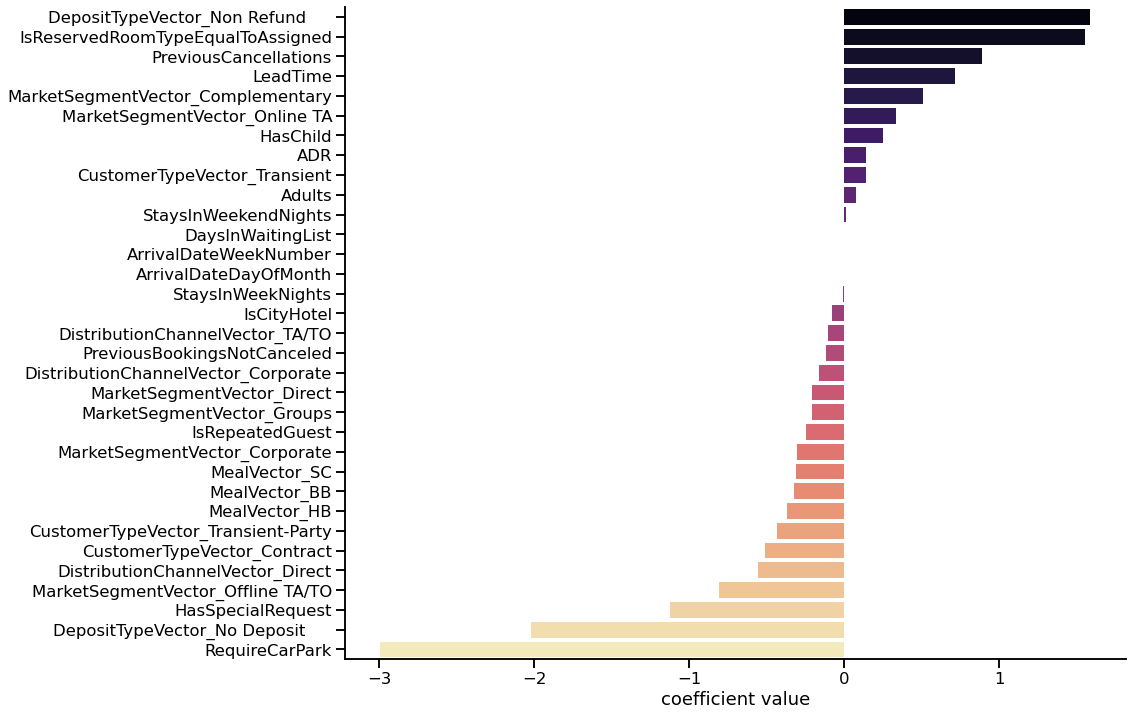

In [23]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_logres) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_logres.bestModel.stages[-1].coefficients
elif (type(cv_logres) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_logres.stages[-1].coefficients

logres_coef = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)
logres_coef['score_abs'] = np.abs(logres_coef['score'])

plot_feature_importance_score(logres_coef, xlabel = 'coefficient value')

### Logistic Regression B

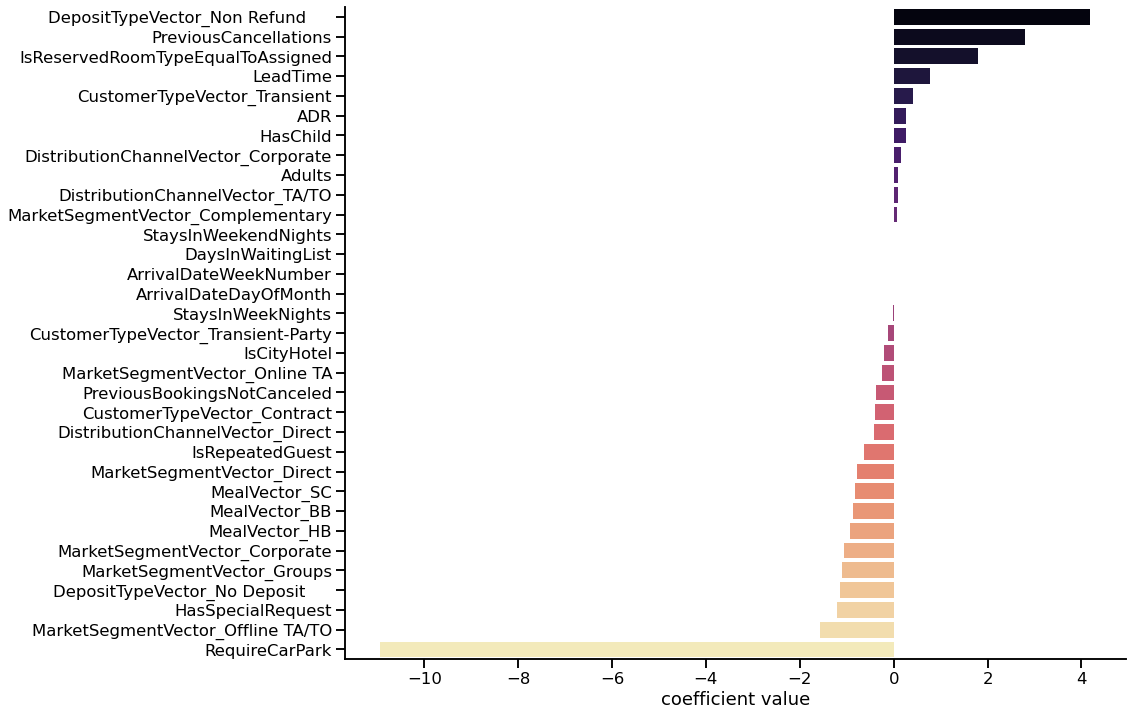

In [24]:
## Extract feature, depends on it is the best model that are loaded from pickled file
## or a newly trained model (still in the form of CrossValidatorModel)

if (type(cv_logres2) == pyspark.ml.tuning.CrossValidatorModel):
    feature_value = cv_logres2.bestModel.stages[-1].coefficients
elif (type(cv_logres2) == pyspark.ml.pipeline.PipelineModel):
    feature_value = cv_logres2.stages[-1].coefficients

logres2_coef = get_feature_importance_score(
    feature_importance = feature_value,
    spark_df = df_train_assembled,
    feature_colname = 'features'
)
logres2_coef['score_abs'] = np.abs(logres2_coef['score'])

plot_feature_importance_score(logres2_coef, xlabel = 'coefficient value')

# 8. Interpretation

## 8.1. Study and Discuss the Mined Patterns


We extract the top 10 important features based on each model, as displayed below. There are some intersections of the top features, e.g., LeadTime is considered important in Decision Tree, Random Forest, and GBDT.

In [25]:
TOP_N_FEATURES = 10
FEATURE_NAME_COL = 'name'

logres_top_features = logres_coef.sort_values(
    by = 'score_abs', 
    ascending = False
).head(TOP_N_FEATURES)[FEATURE_NAME_COL].values

logres2_top_features = logres2_coef.sort_values(
    by = 'score_abs', 
    ascending = False
).head(TOP_N_FEATURES)[FEATURE_NAME_COL].values

df_top_features = pd.DataFrame(
    data = {
        'logistic_regression_A': logres_top_features,
        'logistic_regression_B': logres2_top_features
    }
)

df_top_features

,logistic_regression_A,logistic_regression_B
0,RequireCarPark,RequireCarPark
1,DepositTypeVector_No Deposit,DepositTypeVector_Non Refund
2,DepositTypeVector_Non Refund,PreviousCancellations
3,IsReservedRoomTypeEqualToAssigned,IsReservedRoomTypeEqualToAssigned
4,HasSpecialRequest,MarketSegmentVector_Offline TA/TO
5,PreviousCancellations,HasSpecialRequest
6,MarketSegmentVector_Offline TA/TO,DepositTypeVector_No Deposit
7,LeadTime,MarketSegmentVector_Groups
8,DistributionChannelVector_Direct,MarketSegmentVector_Corporate
9,CustomerTypeVector_Contract,MealVector_HB


There are 13 unique features.

In [26]:
from itertools import chain

top_features = set(chain(*df_top_features.values))
top_features

{'CustomerTypeVector_Contract',
 'DepositTypeVector_No Deposit     ',
 'DepositTypeVector_Non Refund     ',
 'DistributionChannelVector_Direct',
 'HasSpecialRequest',
 'IsReservedRoomTypeEqualToAssigned',
 'LeadTime',
 'MarketSegmentVector_Corporate',
 'MarketSegmentVector_Groups',
 'MarketSegmentVector_Offline TA/TO',
 'MealVector_HB',
 'PreviousCancellations',
 'RequireCarPark'}

## 8.2. Visualise the Data, Results, Models, Patterns

In [28]:
## we use the preformatted dataset from step 3, since it does not in vector form yet & it is already clean
## easier to visualise
import json
from pyspark.sql.types import StructType

## Get schema of the JSON file
with open("hotel_merged_data_preparation_preformatted_schema.json") as f:
    preparation_schema = StructType.fromJson(json.load(f))
    
## Read the JSON file based on the saved schema
df_hotel_prep = spark.read.json('hotel_merged_data_preparation_preformatted.json/',
                                schema = preparation_schema)

In [29]:
df_hotel_prep.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: string (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- DepositType: string (nullable = true)
 |-- Agent: str

### Categorical and features

**Market Segment**

In [46]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_hotel_prep.createOrReplaceTempView('df_hotel')

QUERY = """
    select
      IsCanceled,
      {0},
      count(*) as ct
    from df_hotel
    group by 1,2
""" .format('MarketSegment')

d = sql_con.sql(QUERY).toPandas()

d['pct'] = d['ct'] / d['ct'].sum()

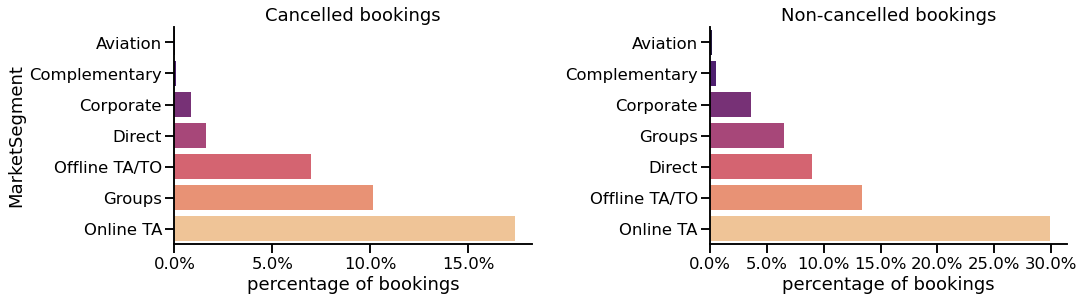

In [47]:
## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == 1)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'MarketSegment',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].set_xlabel('percentage of bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = d[(d['IsCanceled'] == 0)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'MarketSegment',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

**Customer Type**

In [44]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_hotel_prep.createOrReplaceTempView('df_hotel')

QUERY = """
    select
      IsCanceled,
      {0},
      count(*) as ct
    from df_hotel
    group by 1,2
""" .format('CustomerType')

d = sql_con.sql(QUERY).toPandas()

d['pct'] = d['ct'] / d['ct'].sum()

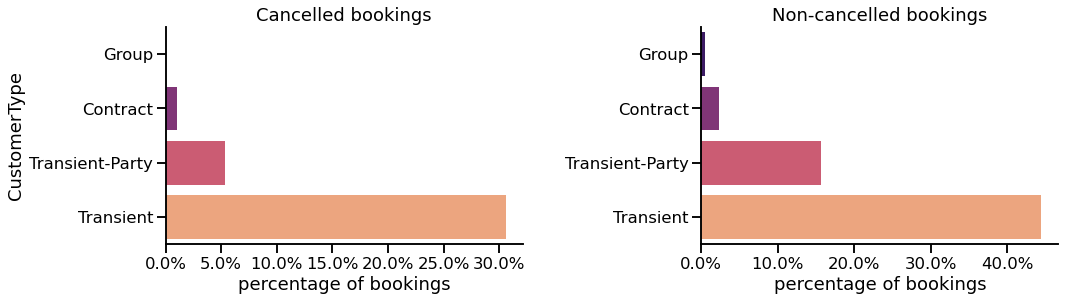

In [45]:
## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == 1)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'CustomerType',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].set_xlabel('percentage of bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = d[(d['IsCanceled'] == 0)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'CustomerType',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

**Distribution Channel**

In [48]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_hotel_prep.createOrReplaceTempView('df_hotel')

QUERY = """
    select
      IsCanceled,
      {0},
      count(*) as ct
    from df_hotel
    group by 1,2
""" .format('DistributionChannel')

d = sql_con.sql(QUERY).toPandas()

d['pct'] = d['ct'] / d['ct'].sum()

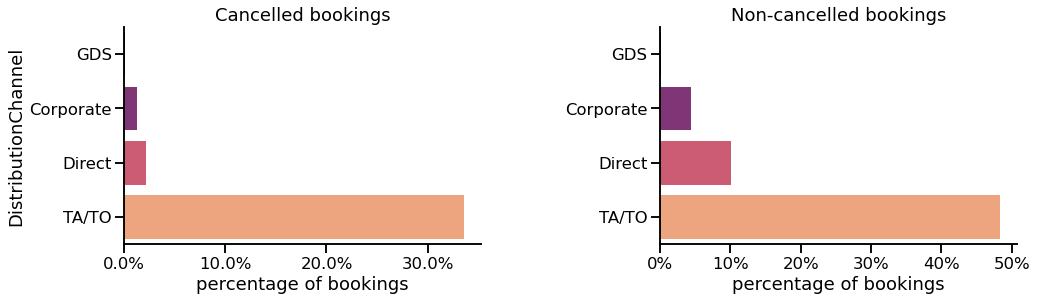

In [49]:
## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == 1)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'DistributionChannel',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].set_xlabel('percentage of bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = d[(d['IsCanceled'] == 0)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'DistributionChannel',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

**Meal**

In [50]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_hotel_prep.createOrReplaceTempView('df_hotel')

QUERY = """
    select
      IsCanceled,
      {0},
      count(*) as ct
    from df_hotel
    group by 1,2
""" .format('Meal')

d = sql_con.sql(QUERY).toPandas()

d['pct'] = d['ct'] / d['ct'].sum()

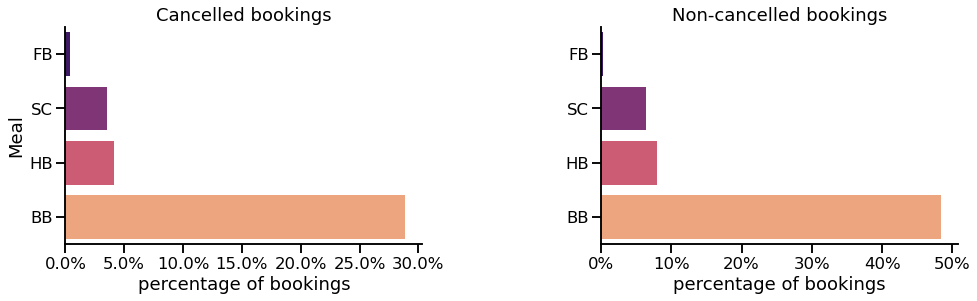

In [51]:
## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == 1)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'Meal',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].set_xlabel('percentage of bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = d[(d['IsCanceled'] == 0)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'Meal',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

## 8.3. Interpret the Results, Models, Patterns

Cancelled bookings:

- more frequently observed in Groups market segment, less frequent in Corporate
- majority of the customers are Transient type; they also frequently cancel the bookings
- hard to be distinguished based on meal type
- mostly created from TA/TO distribution channel

## 8.4. Assess and Evaluate the Results, Models, Patterns

Pyspark version 2.1.1 only provides ROC curve plot for Logistic Regression model. There is a suggestion for workaround [here](https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve), but it does not work when we try it. Hence, we utilise scikit-learn to compute the False Positive Rate and True Positive Rate, then plot the curve. 

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(clf, spark_df, target_colname, predict_colname):
    predictions = clf.transform(spark_df)
    df_pred = predictions.select([target_colname, predict_colname]).toPandas()
    ## Get the probability of predicting the target class
    df_pred['prob'] = df_pred[predict_colname].apply(lambda x: x[1])
    fpr, tpr, threshold = roc_curve(df_pred[target_colname], df_pred['prob'])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    sns.despine();

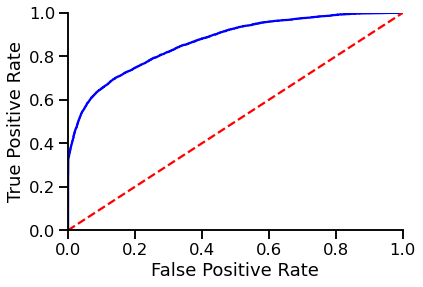

In [31]:
plot_roc_curve(cv_logres, df_test, target_colname='IsCanceled', predict_colname='probability')

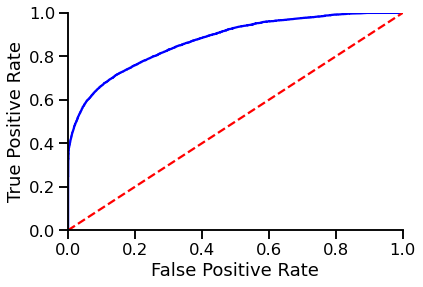

In [32]:
plot_roc_curve(cv_logres2, df_test, target_colname='IsCanceled', predict_colname='probability')